In [27]:
import io
import pandas as pd                     # for reading, manipulating, and displaying data
import requests
from PIL import Image
import os
import math

In [28]:
from helpers import get_file_stats

DATA_URL = 'https://data.labs.loc.gov/free-to-use/' # Base URL of this data package

# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)
pd.DataFrame(stats)

,FileType,Count,Size
0,.jpg,"2,610",1.06GB


In [29]:
metadata_url = f'{DATA_URL}metadata.json'
response = requests.get(metadata_url, timeout=60)
data = response.json()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 2,610 entries.


In [30]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Call_number, Contributors, Date_text, Date, Digitized, Set, Genre, Id, IIIF_manifest, Preview_url, Index, Other_title, Description, Creators, Type_of_resource, Location_text, Other_record_formats, Rights, Source_collection, Language, Lccn, Medium, Mime_type, Notes, Online_format, Original_format, Part_of, Repository, Number_of_files, Shelf_id, Subjects, Subject_headings, Last_updated_in_api, Title, Url, Location


In [31]:
# Since "Subjects" are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['Subjects'].explode().value_counts().iloc[:10].to_frame()

,count
Subjects,
united states,1073
color,827
photographic prints,332
portrait photographs,265
america,236
glass negatives,230
digital photographs,200
american,166
washington (d.c.),153


In [32]:
df_by_subject = df.explode('Subjects')
dc_set = df_by_subject[df_by_subject.Subjects == 'america']
print(f'Found {dc_set.shape[0]:,} items with subject "america"')

Found 236 items with subject "america"


In [33]:
df_files = pd.DataFrame(files)
dc_set_with_images = pd.merge(dc_set, df_files, left_on='Id', right_on='item_id', how='inner')
print(f'Found {dc_set_with_images.shape[0]:,} america items with image files')

Found 236 america items with image files


Downloaded and saved images/image_1.jpg
Downloaded and saved images/image_2.jpg
Downloaded and saved images/image_3.jpg
Downloaded and saved images/image_4.jpg
Downloaded and saved images/image_5.jpg
Downloaded and saved images/image_6.jpg
Downloaded and saved images/image_7.jpg
Downloaded and saved images/image_8.jpg
Downloaded and saved images/image_9.jpg
Downloaded and saved images/image_10.jpg
Downloaded and saved images/image_11.jpg
Downloaded and saved images/image_12.jpg
Downloaded and saved images/image_13.jpg
Downloaded and saved images/image_14.jpg
Downloaded and saved images/image_15.jpg
Downloaded and saved images/image_16.jpg
Downloaded and saved images/image_17.jpg
Downloaded and saved images/image_18.jpg
Downloaded and saved images/image_19.jpg
Downloaded and saved images/image_20.jpg
Downloaded and saved images/image_21.jpg
Downloaded and saved images/image_22.jpg
Downloaded and saved images/image_23.jpg
Downloaded and saved images/image_24.jpg
Downloaded and saved imag

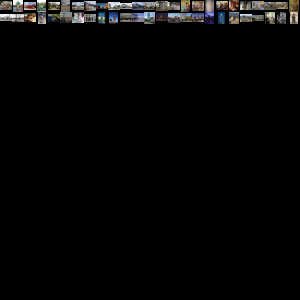

In [34]:
# Set the number of images to process
count = 50  # Set to 50 to download the first 50 images
dc_set_with_images = dc_set_with_images.head(count).reset_index()

# Create images directory if it doesn't exist
if not os.path.exists("images"):
    os.makedirs("images")

# Loop through image URLs and download images
for i, row in dc_set_with_images.iterrows():
    file_url = f'https://{row["object_key"]}'
    response = requests.get(file_url, timeout=60)
    if response.status_code == 200:
        image_filestream = io.BytesIO(response.content)
        image = Image.open(image_filestream)
        
        # Save the image to the images directory
        image_filename = f"images/image_{i + 1}.jpg"
        image.save(image_filename)
        print(f"Downloaded and saved {image_filename}")
    else:
        print(f"Failed to download {file_url}")

# Define image dimensions for the base image
image_w = 300
image_h = 300
cols = math.ceil(count / 2.0)
rows = math.ceil(count / 2.0)
cell_w = image_w / cols
cell_h = image_h / rows

# Create base image
base_image = Image.new("RGB", (image_w, image_h))

# Loop through the downloaded images and arrange them into the base image
for i in range(count):
    image_path = f"images/image_{i + 1}.jpg"
    if os.path.exists(image_path):
        im = Image.open(image_path)

        # Resize it as a thumbnail
        im.thumbnail((cell_w, cell_h))
        tw, th = im.size

        # Position it
        col = i % cols
        row = int(i / cols)
        offset_x = int((cell_w - tw) * 0.5) if tw < cell_w else 0
        offset_y = int((cell_h - th) * 0.5) if th < cell_h else 0
        x = int(col * cell_w + offset_x)
        y = int(row * cell_h + offset_y)

        # Paste it
        base_image.paste(im, (x, y))

# Display the result
display(base_image)